In [131]:
#coding:utf-8

import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import matplotlib.pyplot as plt
import scipy.integrate as sci_integrate
import time
import sys
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    return 96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)
    return 1.0/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (c=G=1 unit))'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt(m_1+m_2)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70




#consts setting
sivalue=2
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=years*sivalue




#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

In [2]:
mc1=chirp_mass(40,40)*m_sun
(96/5.0*np.power(sciconsts.pi,8.0/3)*np.power(mc1,5.0/3)*np.power(1e-3,11.0/3))*years/1e-3

6.7905874161593136e-05

In [25]:
v=np.sqrt((m_1g+m_2g)/a_0)*sciconsts.c/1000
v

3003.3111375119011

In [93]:
2e-11*np.power(10,-33.0/20)/sciconsts.m_p/1000/1e11

2.6769004294936471

In [4]:
5*a_0*a_0*a_0*a_0/(m_1g+m_2g)/m_1g/m_2g/years/64

10125.25654212984

In [29]:
1e17/(1000.0/170/(3003/1000)/(3003/1000)/(3003/1000))

4.59e+17

In [37]:
11.03e-8/sciconsts.m_p/1000

6.59443716071688e+16

In [39]:
sciconsts.astronomical_unit/sciconsts.parsec

4.84813681109536e-06

In [65]:
m1=m_1g/sciconsts.G*np.power(sciconsts.c,3.0)
m2=m_2g/sciconsts.G*np.power(sciconsts.c,3.0)

In [138]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Places a legend on the axes.
    
    To make a legend for lines which already exist on the axes
    (via plot for instance), simply call this function with an iterable
    of strings, one for each legend item. For example::
    
        ax.plot([1, 2, 3])
        ax.legend(['A simple line'])
    
    However, in order to keep the "label" and the legend element
    instance together, it is preferable to specify the label either at
    artist creation, or by calling the
    :meth:`~matplotlib.artist.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        # Overwrite the label by calling the method.
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting with an underscore.
    This is default for all artists, so calling :meth:`leg

In [66]:
def Ra(v):
    return 2*sciconsts.G*(m1+m2)/v/v

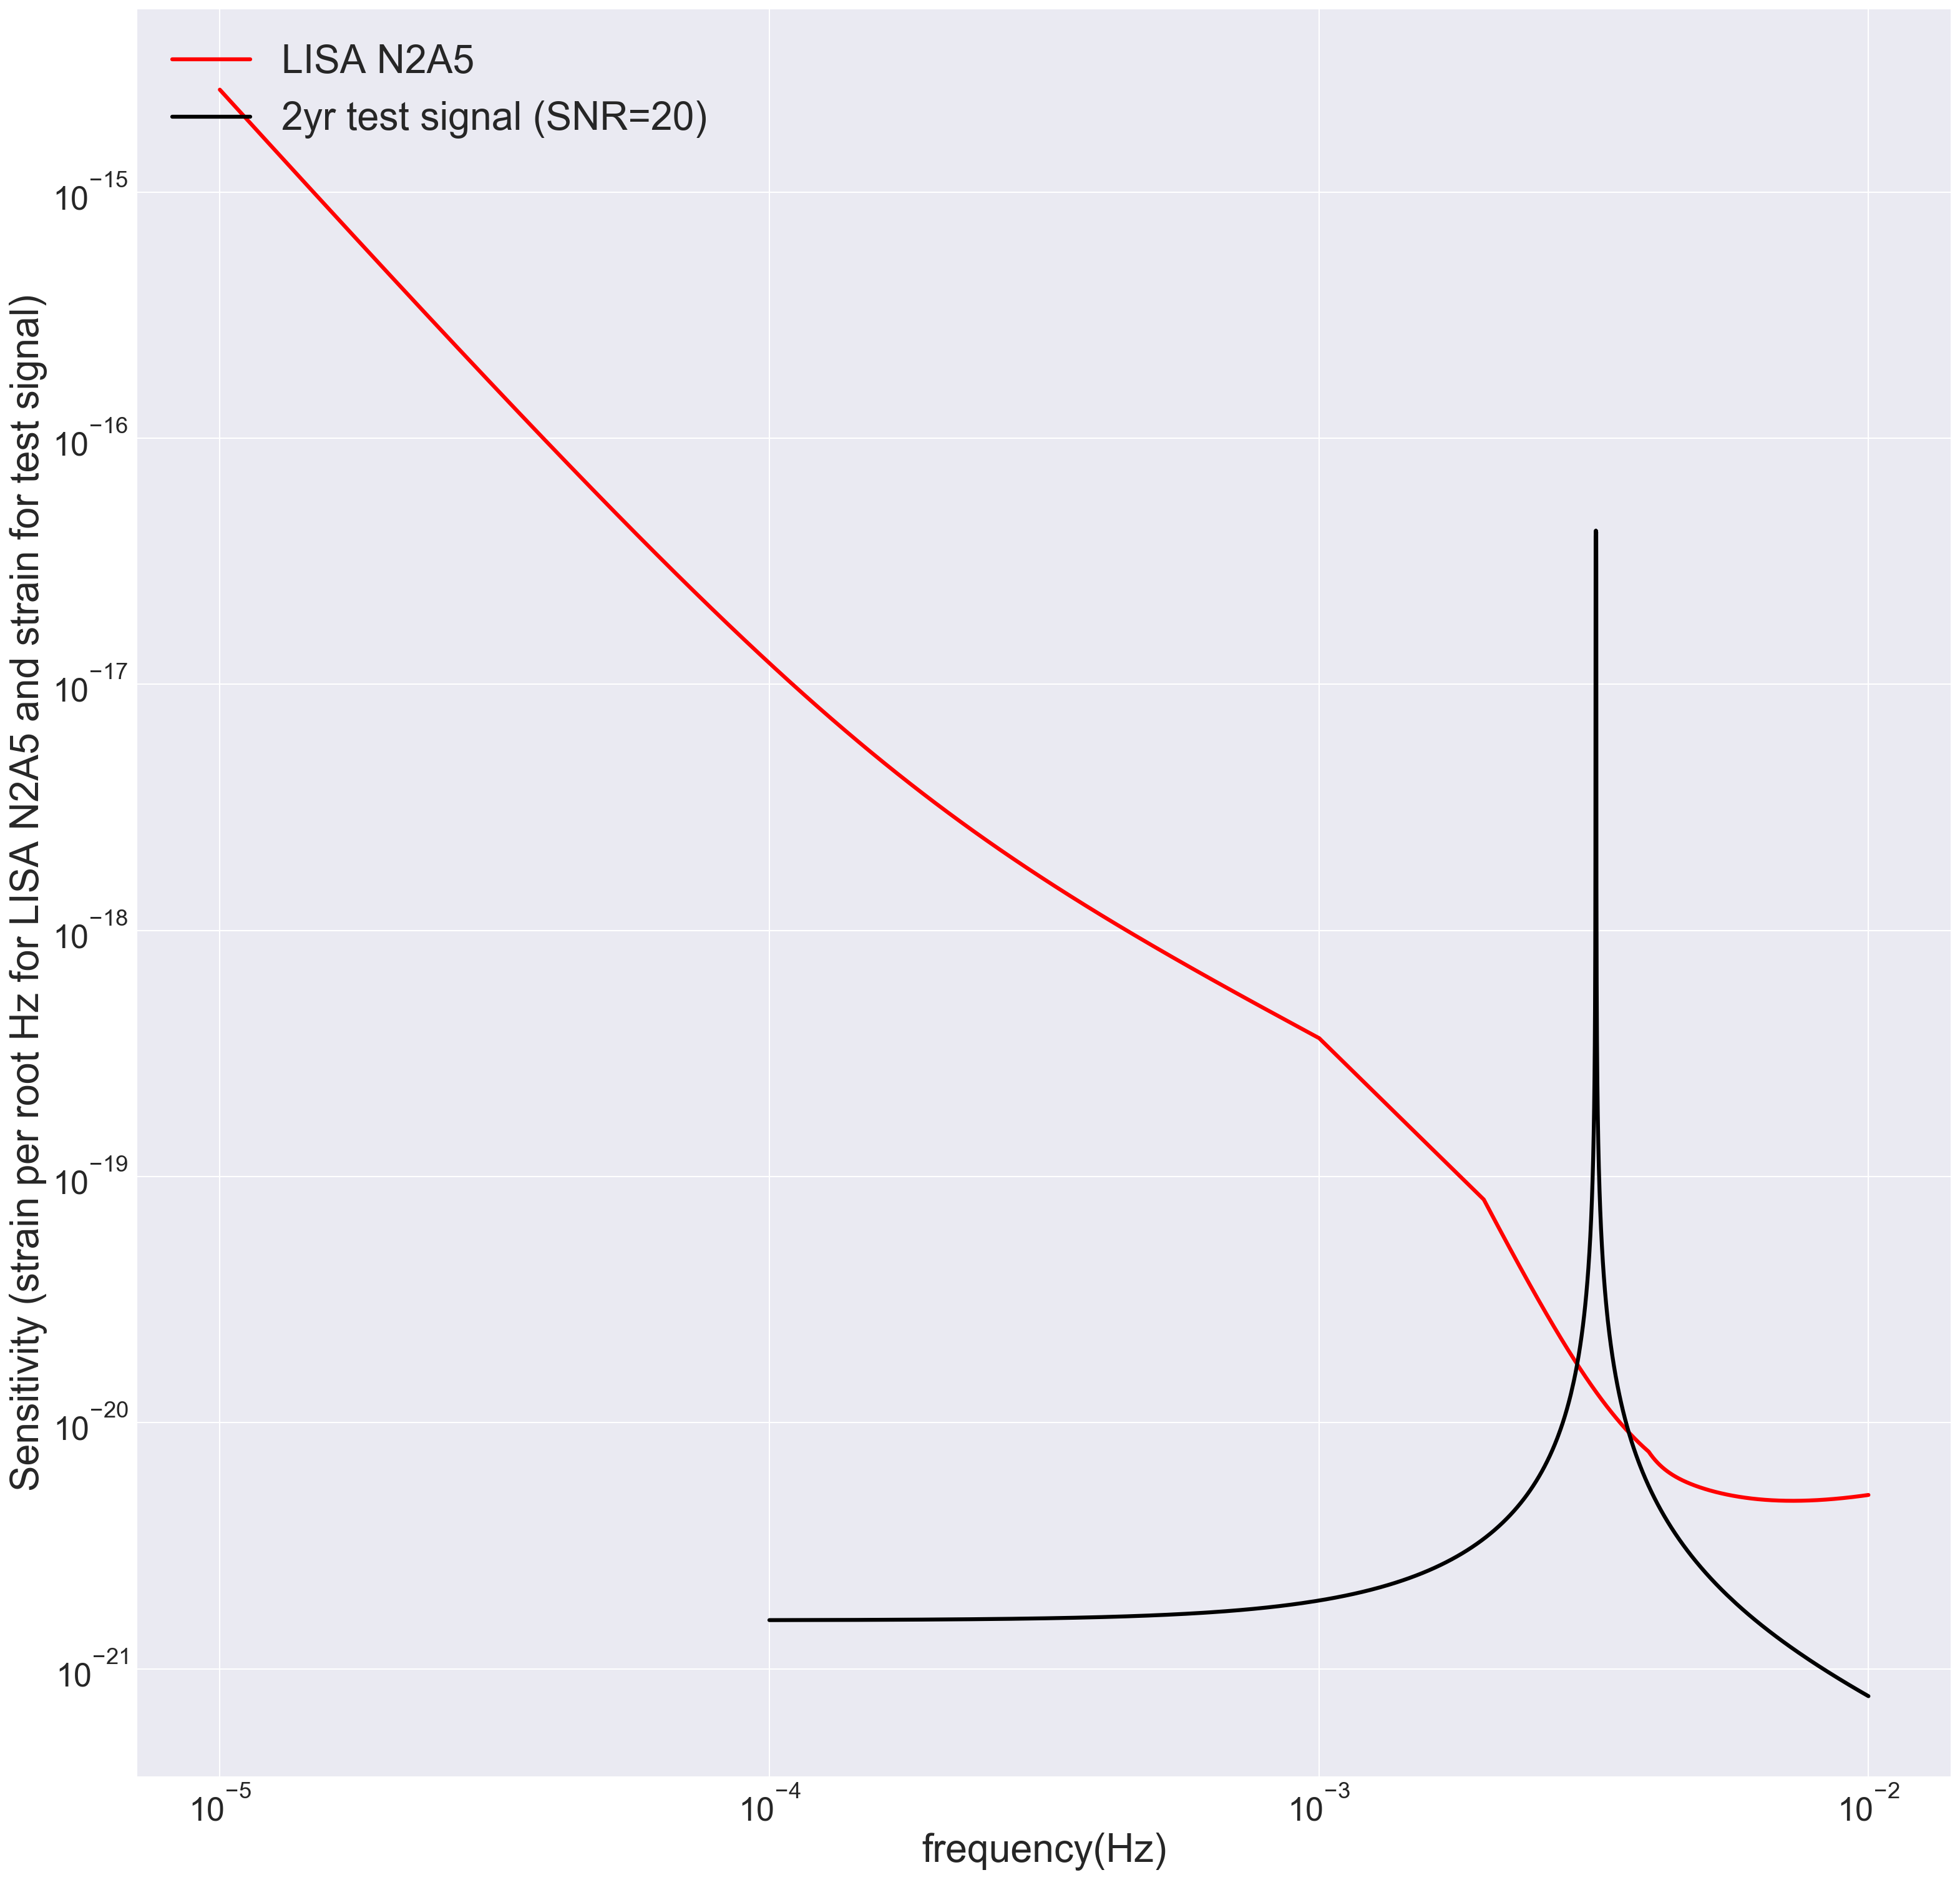

In [142]:
N=10000
fs=np.linspace(-5.0,-2.0,N)
fsig=np.linspace(1e-4,1e-2,N)
resu=hs(fsig)/ratio
fr=np.power(10,fs)
ss=np.zeros(N)
i=0
while i<N:
    ss[i]=S_n_lisa(fr[i])
    i=i+1
fig1=plt.figure(figsize=(25,25),dpi=150)
plt.ylabel('Sensitivity (strain per root Hz for LISA N2A5 and strain for test signal)',fontsize=30)
plt.xlabel('frequency(Hz)',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(fr,np.sqrt(ss),label="LISA N2A5",color='red',linewidth=3)
plt.plot(fsig,resu,label="2yr test signal (SNR=20)",color='black',linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=30)
plt.show()

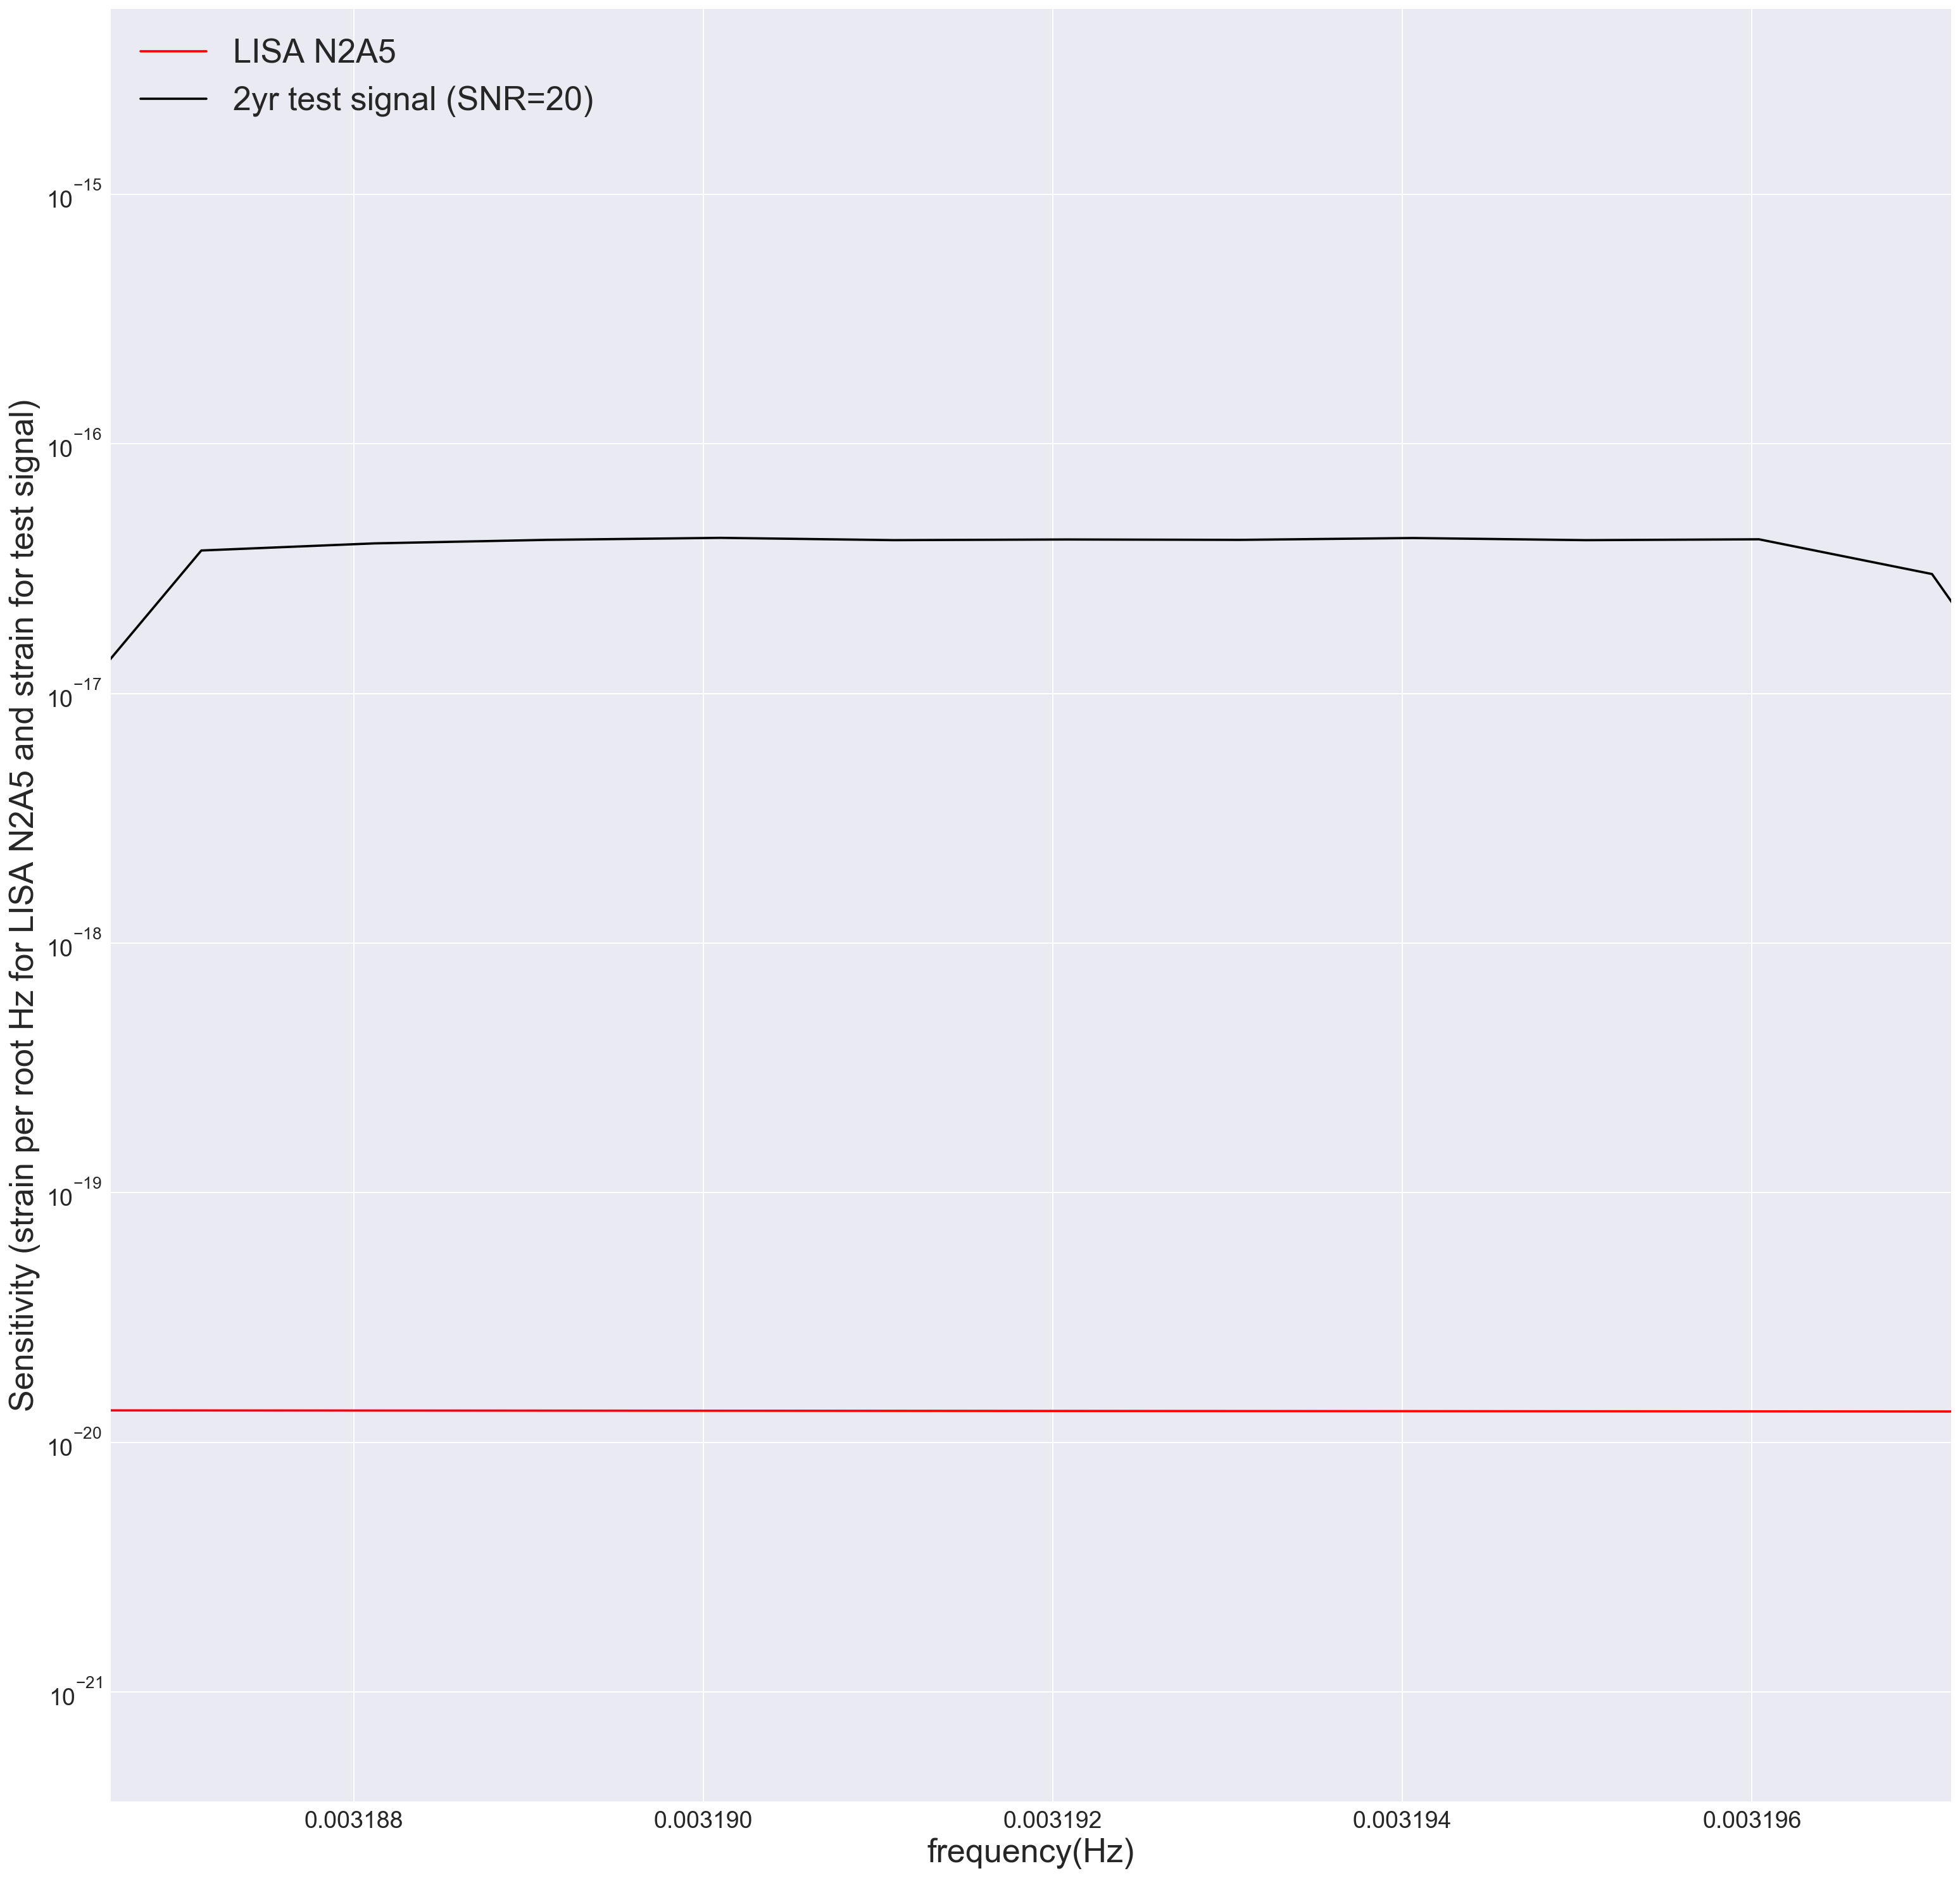

In [134]:
N=10000
fs=np.linspace(-5.0,-2.0,N)
fsig=np.linspace(1e-4,1e-2,N)
resu=hs(fsig)/ratio
fr=np.power(10,fs)
ss=np.zeros(N)
i=0
while i<N:
    ss[i]=S_n_lisa(fr[i])
    i=i+1
fig1=plt.figure(figsize=(25,25),dpi=150)
plt.ylabel('Sensitivity (strain per root Hz for LISA N2A5 and strain for test signal)',fontsize=25)
plt.xlabel('frequency(Hz)',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(fr,np.sqrt(ss),label="LISA N2A5",color='red')
plt.plot(fsig,resu,label="2yr test signal (SNR=20)",color='black')
plt.yscale('log')
plt.xlim(figas,ffgas)
plt.legend(loc='upper left',fontsize=25)
plt.show()

In [57]:
m_1g

5.9075972252604278e-05

In [6]:
3e8/Ra(300000)

0.0049889811208263116

In [7]:
300000/cinm(10000)

NameError: name 'cinm' is not defined

In [75]:
figas

NameError: name 'figas' is not defined

In [8]:
4.96/2/np.sqrt(2)/sciconsts.pi/sciconsts.G/np.power(33,3)/Ra(300000)*300000*np.sqrt(1+8*3e8/33/33/Ra(300000))/1000/years

3.6818559618318856e-11

In [96]:
def cinm(t):
    return np.sqrt(t/sciconsts.m_p*sciconsts.k)
def rhoagn(r):
    return 2e-8*np.power(r/0.01,-33.0/20)
def tagn(r):
    return 800*np.power(r/0.01,-9.0/10)
def cagn(r):
    return 2000*np.power(r/0.01,-9.0/20)
def tauagn(T,v,c):
    m=v/c
    return 4.96/2/np.sqrt(2)/sciconsts.pi/sciconsts.G/np.power(m,3)/Ra(v)*300000*np.sqrt(1+8*3e8/m/m/Ra(v))/1000/years
def tau(T,v):
    c=cinm(T)
    m=v/c
    return 4.96/2/np.sqrt(2)/sciconsts.pi/sciconsts.G/np.power(m,3)/Ra(v)*300000*np.sqrt(1+8*3e8/m/m/Ra(v))/1000/years

In [ ]:
def rho1(mc,r)

In [110]:
r=10000000000
v=np.sqrt(1e6*m_sun/r)*sciconsts.c
tauagn(tagn(r),v,cagn(r))/rhoagn(r)

3.5180699991270297

In [74]:
tau(1e4,100000)/sciconsts.m_p/1e6

65916835038.703285

In [40]:
def tau1(m,v):
    return 4.96/2/np.sqrt(2)/sciconsts.pi/sciconsts.G/np.power(m,3)/Ra(v)*300000*np.sqrt(1+8*3e8/m/m/Ra(v))/1000/years

In [45]:
tau1(4.6,207000)/sciconsts.m_p

3.8709938223794575e+18

In [87]:
(-1.5+m_1g*m_2g/(m_1g+m_2g)/(m_1g+m_2g))*(m_1g+m_2g)/a_0

-0.00012623094104277467

In [10]:
def cinm(t):
    return np.sqrt(t/sciconsts.m_p*sciconsts.k)

In [17]:
1.0/sciconsts.pi/4/sciconsts.G/sciconsts.m_p/1e23/10/1.9891e30

3.5838046795734203e-19

In [21]:
170*1e26*10*1.9891e30/1e18/years*4*sciconsts.pi*sciconsts.G*sciconsts.m_p

0.015041736699449897

In [47]:
0.005*sciconsts.parsec/3e8

514279.59688428824

In [22]:
v

2974.9411790263462

In [36]:
np.sqrt((300*300+81)/2/2.5)

134.22369388450014

In [45]:
(300*300+9*9)/2/v/v

0.0050891073898837414

In [95]:
sciconsts.parsec/sciconsts.astronomical_unit

206264.80624709636

In [21]:
r=1024737798.0262492
-32.0/5/np.power(r,5.0)*np.power(40*m_sun*40*m_sun,2.0)*(80*m_sun)*np.power(sciconsts.c,5.0)/sciconsts.G

-1.2220467992074727e-10

In [132]:

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]*1e70
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=2500)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
print Aval,Aerr,Aerr/Aval
ratio=Aval/20

45839494.4929 31886.9183413 0.000695621072921


In [121]:
ratio=Aval/20

In [79]:
fd=1.5*figas/1000/years

In [83]:
a=5.0/96*np.power(figas,-11.0/3)*fd/np.power(sciconsts.pi,8.0/3)

In [87]:
np.power(a,3.0/5)/m_sun

34.917056228763975

In [3]:
help(sci_integrate.quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the 

In [ ]:


# In[78]:


# sciode
def df_dtode(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    result=96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
    return result


# In[102]:

def find_max2(m):
    mcv=m[0]*m_sun
    smrv=m[1]
    figas=m[2]
    ffgas=m[3]
    sv=solvem(mcv,smrv)
    m1v=sv[0]
    m2v=sv[1]
    n2=10000
    ts=np.linspace(0,t_scale,n2)
    yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
    ftv=sci_interpolate.interp1d(ts,yf.T[0])
    fr=ftv(ts)
    phiv1=np.zeros(n2)
    i=0
    while i<n2:
        phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
        i=i+1
    phiv=sci_interpolate.interp1d(ts,phiv1)
    
    rs=np.zeros(n2)
    rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])
    
    for i in range(1,n2,1):
        rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])
    
    rv=sci_interpolate.interp1d(ts,rs)
    
    t_scalev=ts[n2-1]
    t=np.linspace(0,t_scalev,num=Ng)
    hv=m1v*m2v/rv(t)*np.cos(phiv(t))/1e70
    xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
    hfvac1=fft.fft(hv)
    hfvac_abs=abs(hfvac1)
    hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
    hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
    hvacr=sci_interpolate.interp1d(xs,hfvac2)
    anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
    B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
    Bval=np.sqrt(B[0])
    Berr=0.5/Bval*B[1]
    print Bval,Berr
    sys.stdout.flush()
    #phi max finding
    phinum=100
    phics=np.linspace(0,2*sciconsts.pi,phinum)
    ffmax=0
    errmax=0
    phimaxpos=0
    for phic in phics:
        AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
        ff=abs(AB[0]/Aval/Bval)
        err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
        #err1=abs(1*AB[1]/AB[0])+abs(1.0/Aval*Aerr)+abs(1.0/Bval*Berr)
        if ff>ffmax:
            ffmax=ff
            errmax=err
            phimaxpos=phic
    print ffmax,errmax,m[0],m[1],phimaxpos
    sys.stdout.flush()
    return ffmax,errmax,m[0],m[1],phimaxpos


In [143]:
figas

0.0031866120878530821

In [144]:
S_n_lisa(figas)

1.8048388963401123e-40

In [146]:
chirp_mass(m_1g,m_2g)/m_sun

8.7055056329612519

In [148]:
def x(T,FF):
    r=np.sqrt(1.0/2/(1-FF))
    result=10*np.power(8.7055056329612519/10,5.0/3)*np.power(T/3,0.5)*np.power(1.805,-0.5)*np.power(figas/0.003,2.0/3)/r*10
#mpc
    return result